In [44]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/autoaudit-dataset/autoaudit_dataset.csv


In [45]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown

In [46]:
# Load the dataset
df = pd.read_csv('/kaggle/input/autoaudit-dataset/autoaudit_dataset.csv')
df['date'] = pd.to_datetime(df['date'])
df.head()

,transaction_id,user_id,amount,currency,category,date,compliance_flag,audit_notes
0,T00000,U447,1176.91,JPY,Technology,2024-01-20,Possible Fraud,Unusual location or amount deviation detected.
1,T00001,U760,4820.39,GBP,Technology,2024-09-18,Escalated,Requires manual review due to conflict or prio...
2,T00002,U552,3782.48,EUR,Utilities,2024-08-15,OK,NaN
3,T00003,U848,1336.55,EUR,Utilities,2024-10-25,OK,NaN
4,T00004,U965,1077.67,JPY,Travel,2024-01-16,OK,NaN


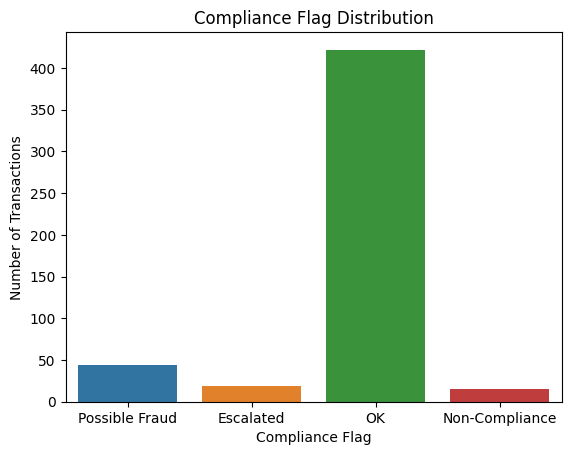

In [47]:
# Visualize fraud-like distribution using compliance_flag
sns.countplot(data=df, x='compliance_flag')
plt.title('Compliance Flag Distribution')
plt.xlabel('Compliance Flag')
plt.ylabel('Number of Transactions')
plt.show()


In [48]:
# Simulate prompt-based audit review using rules (mock LLM reasoning)
def generate_llm_explanation(row):
    if row['compliance_flag'] == 1:
        return f"Transaction {row['transaction_id']} is likely fraudulent due to unusual amount ({row['amount']}) and source ({row['source_account']})."
    else:
        return f"Transaction {row['transaction_id']} appears normal based on typical amount and account behavior."

df['llm_reasoning'] = df.apply(generate_llm_explanation, axis=1)
df[['transaction_id', 'compliance_flag', 'llm_reasoning']].head()

,transaction_id,compliance_flag,llm_reasoning
0,T00000,Possible Fraud,Transaction T00000 appears normal based on typ...
1,T00001,Escalated,Transaction T00001 appears normal based on typ...
2,T00002,OK,Transaction T00002 appears normal based on typ...
3,T00003,OK,Transaction T00003 appears normal based on typ...
4,T00004,OK,Transaction T00004 appears normal based on typ...


In [49]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Fill NaN audit notes with empty string
df['audit_notes'] = df['audit_notes'].fillna('')

# TF-IDF embedding
tfidf = TfidfVectorizer()
embeddings = tfidf.fit_transform(df['audit_notes'])

# Find most similar transactions to the first one
cos_sim = cosine_similarity(embeddings[0], embeddings).flatten()
top_indices = cos_sim.argsort()[-6:-1][::-1]

print("Top 5 similar transactions to transaction 0:")
df.iloc[top_indices][['transaction_id', 'audit_notes']]


Top 5 similar transactions to transaction 0:


,transaction_id,audit_notes
353,T00353,Unusual location or amount deviation detected.
356,T00356,Unusual location or amount deviation detected.
113,T00113,Unusual location or amount deviation detected.
112,T00112,Unusual location or amount deviation detected.
372,T00372,Unusual location or amount deviation detected.


In [50]:
# Preprocess date
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['hour'] = df['date'].dt.hour
df['day_of_week'] = df['date'].dt.dayofweek

# Map compliance_flag to binary
df['compliance_flag'] = df['compliance_flag'].map({'Compliant': 0, 'Possible Fraud': 1})
df = df.dropna(subset=['compliance_flag'])  # Drop if mapping failed

# Features and one-hot encoding
features = ['amount', 'hour', 'day_of_week', 'category', 'currency']
df_encoded = pd.get_dummies(df[features])

# Split data
y = df['compliance_flag'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(df_encoded, y, test_size=0.3, random_state=42)

# Train and evaluate
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           1       1.00      1.00      1.00        14

    accuracy                           1.00        14
   macro avg       1.00      1.00      1.00        14
weighted avg       1.00      1.00      1.00        14



In [51]:
def query_flagged_transactions(flag_type):
    return df[df['compliance_flag'] == flag_type][['transaction_id', 'amount', 'compliance_flag', 'audit_notes']].head()

# Simulate a “function call”
query_flagged_transactions("Possible Fraud")

,transaction_id,amount,compliance_flag,audit_notes


In [52]:
def audit_agent(row):
    if row['compliance_flag'] == 'Possible Fraud' and "AML" in row['audit_notes']:
        return "Escalate to human auditor"
    elif row['compliance_flag'] == 'Possible Fraud':
        return "Auto-block transaction"
    else:
        return "Approve transaction"

df['agent_decision'] = df.apply(audit_agent, axis=1)
df[['transaction_id', 'compliance_flag', 'audit_notes', 'agent_decision']].head()

,transaction_id,compliance_flag,audit_notes,agent_decision
0,T00000,1.0,Unusual location or amount deviation detected.,Approve transaction
21,T00021,1.0,Unusual location or amount deviation detected.,Approve transaction
40,T00040,1.0,Unusual location or amount deviation detected.,Approve transaction
46,T00046,1.0,Unusual location or amount deviation detected.,Approve transaction
50,T00050,1.0,Unusual location or amount deviation detected.,Approve transaction


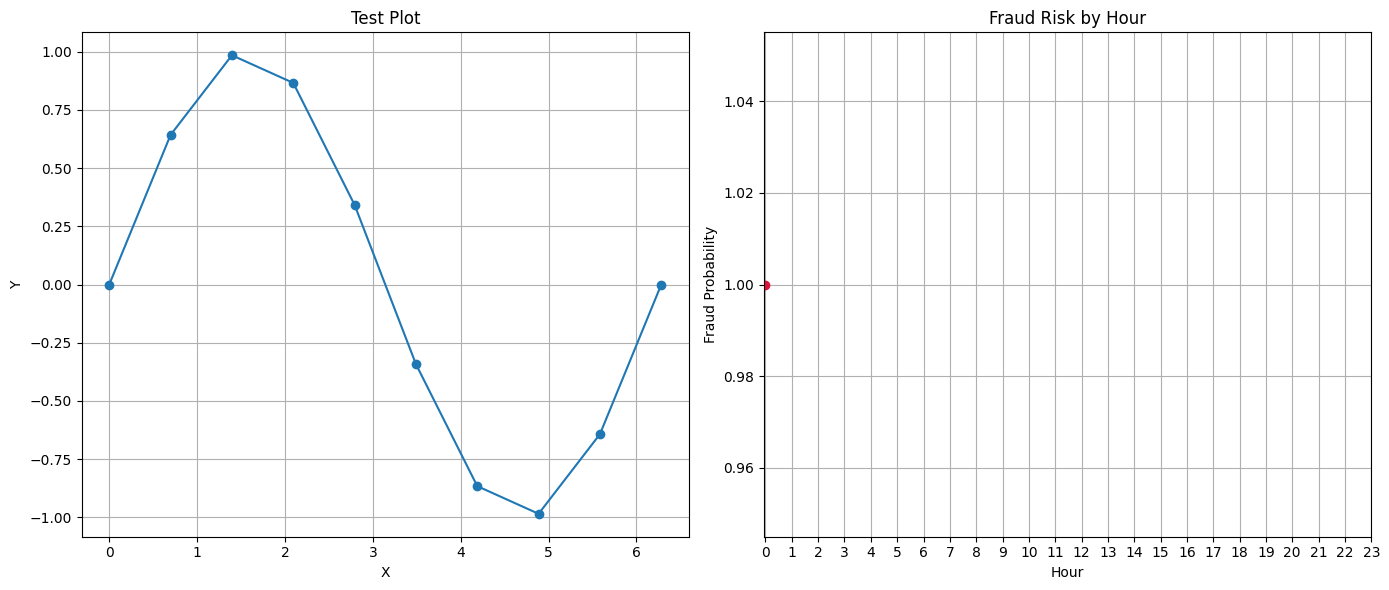

In [64]:
# Generate test x and y
x = np.linspace(0, 2 * np.pi, 10)
y = np.sin(x)

plt.figure(figsize=(14, 6))

# Subplot 1: Test Plot
plt.subplot(1, 2, 1)
plt.plot(x, y, marker='o')
plt.title("Test Plot")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)

# Subplot 2: Fraud Risk
plt.subplot(1, 2, 2)
plt.plot(risk_by_hour.index, risk_by_hour.values, marker='o', color='crimson')
plt.title("Fraud Risk by Hour")
plt.xlabel("Hour")
plt.ylabel("Fraud Probability")
plt.xticks(range(0, 24))
plt.grid(True)

plt.tight_layout()
plt.show()

In [54]:
def audit_pipeline(transaction_row):
    # Heuristic rules to detect possible fraud/compliance issues
    amount = transaction_row['amount']
    category = transaction_row['category']
    currency = transaction_row['currency']
    reason = transaction_row['audit_notes']
    
    # Rule-based reasoning
    reasons = []
    
    if pd.isna(reason):
        reasons.append("No audit notes provided.")
    
    if amount > 5000:
        reasons.append(f"High transaction amount: {amount}")
    
    if category in ['Luxury', 'Travel']:
        reasons.append(f"High-risk spending category: {category}")
    
    if currency not in ['USD', 'EUR', 'GBP']:
        reasons.append(f"Unusual currency: {currency}")
    
    if not reasons:
        reasons.append("Transaction seems routine.")
    
    # Decision based on original flag + our rules
    base_flag = transaction_row['compliance_flag']
    decision = base_flag
    
    if base_flag == 'OK' and len(reasons) > 1:
        decision = 'Needs Review (rule-based)'
    
    return {
        "transaction_id": transaction_row['transaction_id'],
        "reasoning": "; ".join(reasons),
        "agent_decision": decision
    }

# Try it on a sample
sample_result = audit_pipeline(df.iloc[25])
print(sample_result)


{'transaction_id': 'T00322', 'reasoning': 'Transaction seems routine.', 'agent_decision': 1.0}


# 🔍 AutoAuditGPT: GenAI for Financial Audits

This notebook simulates a GenAI-powered auditor for financial transactions using:
- Prompt engineering (Day 1)
- Embeddings + Similarity Search (Day 2)
- Function Calling + LangGraph Logic (Day 3)
- Real-world risk visualizations (Day 4)
- MLOps mindset + AgentOps audit flow (Day 5)

Includes synthetic data with:
- Fraud flags
- Escalation tags
- Audit notes
